In [1]:
# Instalação de pacotes necessários (caso ainda não estejam instalados)
!pip install scipy
!pip install shap
!pip install xgboost

In [2]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Desativar avisos desnecessários
warnings.filterwarnings('ignore')

# Estatística e Seleção de Características 
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.interpolate import make_interp_spline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

# Modelos de Machine Learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb

# Pré-processamento
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Seleção e Otimização de Modelos
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, train_test_split

# Métricas de Avaliação
from sklearn.metrics import (
    precision_recall_curve, roc_curve, accuracy_score, 
    precision_score, recall_score, f1_score, confusion_matrix, 
    ConfusionMatrixDisplay, roc_curve, auc
)

# SHAP para Interpretabilidade de Modelos
import shap


In [3]:
data = pd.read_excel(r'data_model.xlsx')
data

,idstore,sku,brand,oldpvp,weight (g),Payment_method,Margin (%),Profit (€),perc_expiring_sku,expiring_date,...,expiring_days,discount_rounded,labelling_weekday,labelling_day,labelling_month,sell_weekday,sell_day,sell_month,label_till_sale,exp_till_sale
0,1,1,Marca 1,4.22,260,Card,16,0.3376,0.010050,2021-10-03,...,199.0,0.5,Friday,1,10,Saturday,2.0,10.0,1,1
1,1,1,Marca 1,3.96,260,,16,0.3168,0.005025,2021-10-02,...,199.0,0.5,Friday,1,10,NaN,NaN,NaN,0,0
2,1,1,Marca 1,4.74,260,Cash,16,0.3792,0.010050,2021-10-03,...,199.0,0.5,Friday,1,10,Sunday,3.0,10.0,2,0
3,1,1,Marca 1,4.20,260,Card,16,0.3360,0.010050,2021-10-03,...,199.0,0.5,Friday,1,10,Saturday,2.0,10.0,1,1
4,1,1,Marca 1,4.62,260,Cash,16,0.3696,0.010050,2021-10-03,...,199.0,0.5,Friday,1,10,Sunday,3.0,10.0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150046,193,318,Marca 2,2.49,97,,11,0.1364,0.100629,2021-10-19,...,159.0,0.5,Sunday,3,10,NaN,NaN,NaN,0,0
150047,203,318,Marca 2,2.49,97,Cash,11,0.1364,0.113208,2021-10-19,...,159.0,0.5,Friday,1,10,Saturday,2.0,10.0,1,17
150048,203,318,Marca 2,2.49,97,Cash,11,0.1364,0.113208,2021-10-19,...,159.0,0.5,Friday,1,10,Saturday,2.0,10.0,1,17
150049,139,319,Marca 24,3.49,141,Cash,19,0.4636,0.092437,2021-10-17,...,119.0,0.3,Wednesday,6,10,Monday,11.0,10.0,5,6


In [4]:
data = data.drop(columns=['sell_day','sell_month','sell_date','labelling_day','labelling_month','labelling_date','discount','expiring_date'])
data['sell_weekday'].fillna('Not Sold', inplace=True)

# Removemos as datas porque já as utilizámos para calcular outras variáveis,
# Removemos o desconto porque já temos o desconto arredondado,
# e removemos o mês e o dia porque, com base na análise no Power BI, verificámos que essa informação era redundante.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150051 entries, 0 to 150050
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   idstore            150051 non-null  int64  
 1   sku                150051 non-null  int64  
 2   brand              150051 non-null  object 
 3   oldpvp             150051 non-null  float64
 4   weight (g)         150051 non-null  int64  
 5   Payment_method     150051 non-null  object 
 6   Margin (%)         150051 non-null  int64  
 7   Profit (€)         150051 non-null  float64
 8   perc_expiring_sku  150051 non-null  float64
 9   sold               150051 non-null  int64  
 10  type               150051 non-null  object 
 11  district           150051 non-null  object 
 12  new_pvp            150051 non-null  float64
 13  exp_days_label     150051 non-null  int64  
 14  expiring_days      150051 non-null  float64
 15  discount_rounded   150051 non-null  float64
 16  la

In [6]:
skf = StratifiedKFold(n_splits = 5, random_state = 99, shuffle = True) 

In [7]:
X = data.drop('sold', axis = 1)
y = data['sold'].copy()

# Remoção da variavel dependente do x (sold)

### Teste Chi-square para Avaliar a Importância de Variáveis Categóricas (y)

In [8]:
def apply_chisquare(X, y, var_name, alpha=0.05):        
    
    dfObserved = pd.crosstab(X, y)
    
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved)

    dfExpected = pd.DataFrame(expected, index=dfObserved.index, columns=dfObserved.columns)
    
    # Verificar a significância do valor-p
    if p < alpha:
        result = f"✅ {var_name} é IMPORTANTE para a previsão."
    else:
        result = f"❌ {var_name} NÃO é um preditor importante. (Considere remover {var_name} do modelo.)"
    
    print(result)


### Seleciona as melhores variáveis categóricas utilizando o teste Chi-square dentro do Stratified K-Fold.

In [9]:
def select_best_cat_features(X, y, skf_splits=5):

    skf = StratifiedKFold(n_splits=skf_splits, shuffle=True, random_state=99)
    best_features_per_fold = {}

    for count, (train_index, val_index) in enumerate(skf.split(X, y), start=1):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        print('\n' + '=' * 80)
        print(f'                         DIVISÃO {count}                         ')
        print('=' * 80)

        # Selecionar dinamicamente as variáveis categóricas
        categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

        # Armazenar as melhores variáveis para esta iteração
        selected_features = []

        for var in categorical_features:
            if apply_chisquare(X_train[var], y_train, var):
                selected_features.append(var)

        # Guardar as variáveis selecionadas para esta iteração.
        best_features_per_fold[count] = selected_features
        print(f"\n✅ Variáveis selecionadas para a divisão {count}: {selected_features}\n")

    return best_features_per_fold


In [10]:
select_best_cat_features(X,y)


                         DIVISÃO 1                         
✅ brand é IMPORTANTE para a previsão.
✅ Payment_method é IMPORTANTE para a previsão.
✅ type é IMPORTANTE para a previsão.
✅ district é IMPORTANTE para a previsão.
✅ labelling_weekday é IMPORTANTE para a previsão.
✅ sell_weekday é IMPORTANTE para a previsão.

✅ Variáveis selecionadas para a divisão 1: []


                         DIVISÃO 2                         
✅ brand é IMPORTANTE para a previsão.
✅ Payment_method é IMPORTANTE para a previsão.
✅ type é IMPORTANTE para a previsão.
✅ district é IMPORTANTE para a previsão.
✅ labelling_weekday é IMPORTANTE para a previsão.
✅ sell_weekday é IMPORTANTE para a previsão.

✅ Variáveis selecionadas para a divisão 2: []


                         DIVISÃO 3                         
✅ brand é IMPORTANTE para a previsão.
✅ Payment_method é IMPORTANTE para a previsão.
✅ type é IMPORTANTE para a previsão.
✅ district é IMPORTANTE para a previsão.
✅ labelling_weekday é IMPORTANTE para a pr

{1: [], 2: [], 3: [], 4: [], 5: []}

### Calcular a variância de todas as colunas numéricas no conjunto de dados de treino.

In [11]:
def apply_variance(X_train):

    variance_values = X_train.var(numeric_only=True)
    formatted_variance = variance_values.apply(lambda x: f"{x:.2f}")

    print("\n📊 Variância das variáveis numéricas:\n")
    print(formatted_variance)
    
    return variance_values 


In [12]:
def select_features_variance(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        print('_________________________________________________________________________________________________\n')
        print('                                     DIVISÃO ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        apply_variance(X_train)
        count+=1

In [13]:
select_features_variance(X,y)

_________________________________________________________________________________________________

                                     DIVISÃO 1                                    
_________________________________________________________________________________________________

📊 Variância das variáveis numéricas:

idstore              7582.14
sku                  7607.98
oldpvp                  0.32
weight (g)           3416.26
Margin (%)             10.91
Profit (€)              0.01
perc_expiring_sku       0.05
new_pvp                 0.15
exp_days_label          1.79
expiring_days         425.55
discount_rounded        0.00
label_till_sale         0.59
exp_till_sale           0.73
dtype: object
_________________________________________________________________________________________________

                                     DIVISÃO 2                                    
_________________________________________________________________________________________________

📊 Variânc

### Análise de Correlação

In [14]:
def cor_heatmap(cor_matrix, title="Mapa de Correlação", figsize=(14, 7)):
   
    # Remover valores NaN e infinitos para evitar erros
    cor_matrix = cor_matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='all').dropna(axis=0, how='all')

    plt.figure(figsize=figsize)
    
    sns.heatmap(
        data=cor_matrix, 
        annot=True, 
        fmt=".2f", 
        linewidths=1,
        cbar=True, 
        square=True, 
        annot_kws={"size": 10}, 
    )

    plt.title(title, fontsize=14, fontweight='bold', pad=15)

    plt.show()

In [15]:
def apply_correlation(X_train):
    correlation_data = X_train.copy()
    matrix = correlation_data.corr(method = 'spearman', numeric_only=True)
    cor_heatmap(matrix)

In [16]:
def redundant_features(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
       
        print('_________________________________________________________________________________________________\n')
        print('                                     DIVISÃO ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')
        
        apply_correlation(X_train)
        
        count+=1

_________________________________________________________________________________________________

                                     DIVISÃO 1                                    
_________________________________________________________________________________________________


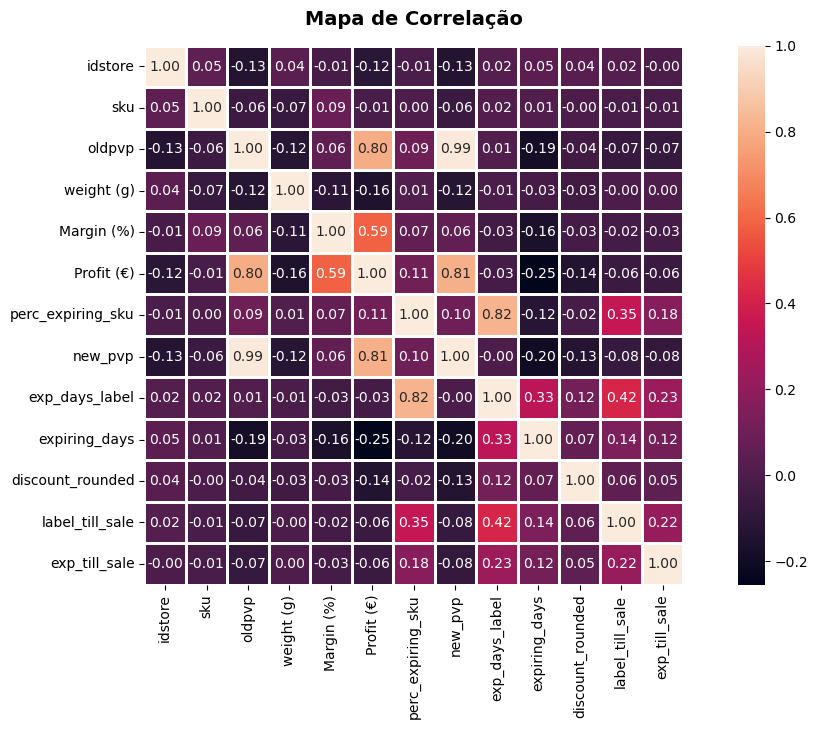

_________________________________________________________________________________________________

                                     DIVISÃO 2                                    
_________________________________________________________________________________________________


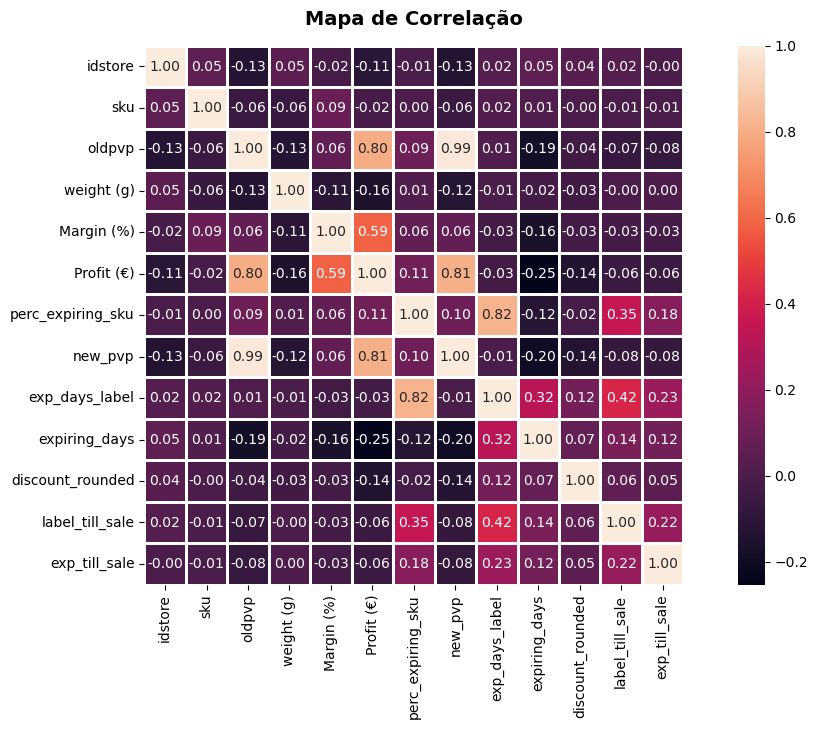

_________________________________________________________________________________________________

                                     DIVISÃO 3                                    
_________________________________________________________________________________________________


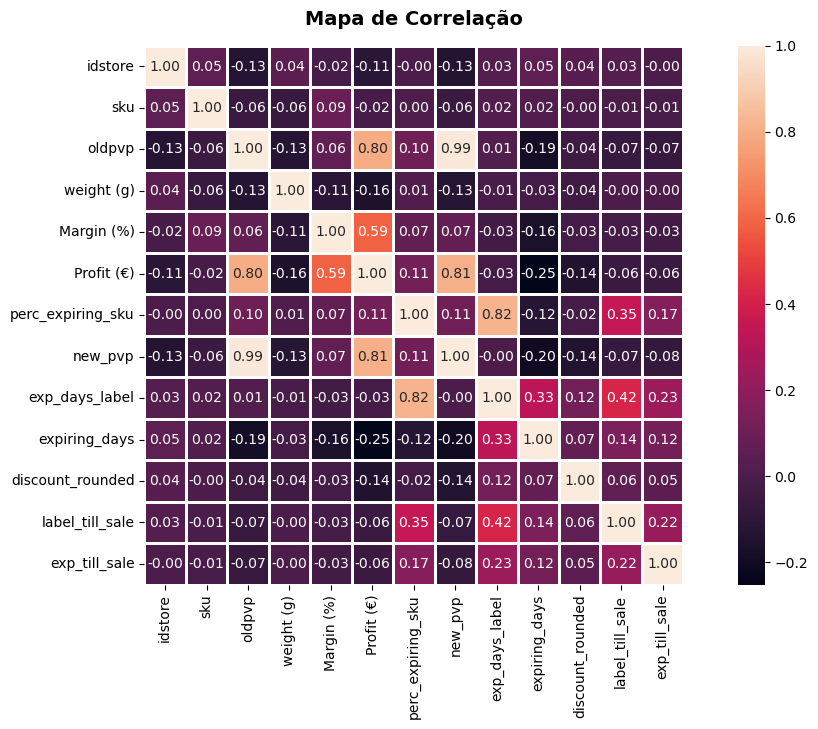

_________________________________________________________________________________________________

                                     DIVISÃO 4                                    
_________________________________________________________________________________________________


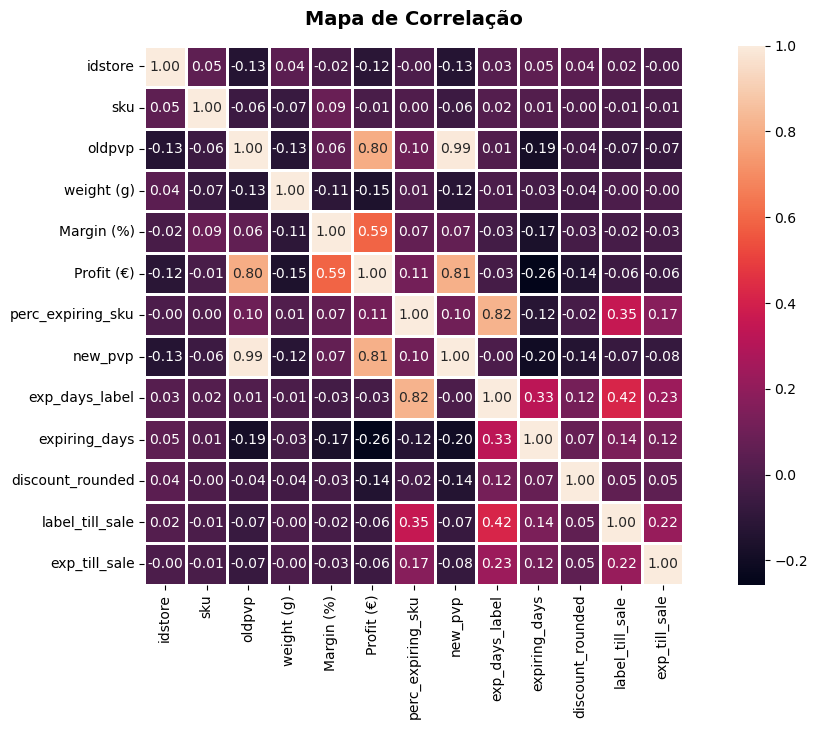

_________________________________________________________________________________________________

                                     DIVISÃO 5                                    
_________________________________________________________________________________________________


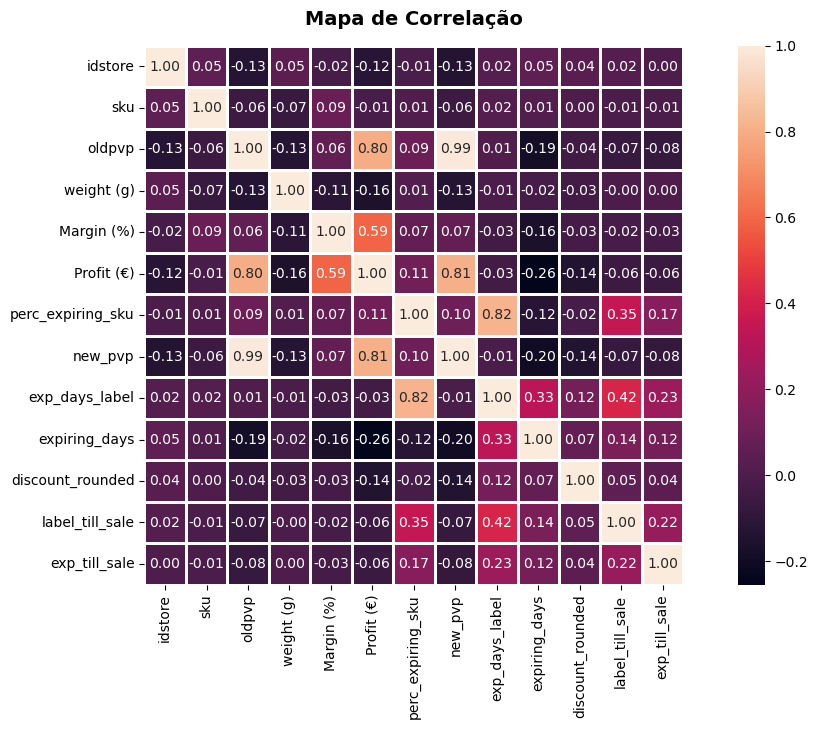

In [17]:
redundant_features(X, y)

### Variáveis Redundantes - Correlação de Spearman (Correlação superior a |0.8|)

| Combinação | Divisão 1 | Divisão 2 | Divisão 3 | Divisão 4 | Divisão 5 |
| --- | --- | --- | --- | --- | --- |
| Profit (€) Vs oldpvp | 0.80 | 0.80 | 0.80 | 0.80 | 0.80 |
| Profit (€) Vs new_pvp | 0.81 | 0.81 | 0.81 | 0.81 | 0.81 |
| oldpvp Vs new_pvp | 0.99 | 0.99 | 0.99 | 0.99 | 0.99 |
| exp_days_label Vs perc_expiring_sku | 0.82 | 0.82 | 0.82 | 0.82 | 0.82 |



In [18]:
def plot_importance(variables,name):
    imp_features = variables.sort_values()
    plt.figure(figsize=(4,5))
    imp_features.plot(kind = "barh")
    plt.title("Importância das variáveis usando " + name + " Model")
    plt.show()

In [19]:
def apply_decision_tree(X_train, y_train):
    # Modelo Decision Tree com hiperparâmetros ajustados
    dt = DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=99)
    dt.fit(X_train, y_train)

    # Importância das variáveis usando
    feature_importances = pd.Series(dt.feature_importances_, index=X_train.columns)
    
    print("\n🔹 Variáveis mais importantes pela Decision Tree:")
    print(feature_importances.sort_values(ascending=False).head(10))

    plot_importance(feature_importances, 'Decision Tree')

def apply_random_forest(X_train, y_train):
    # Modelo Random Forest
    rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10, random_state=99, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Importância das variáveis
    feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    
    print("\n🔹 Variáveis mais importantes pelo Random Forest:")
    print(feature_importances.sort_values(ascending=False).head(10))

    # Visualizar importâncias
    plot_importance(feature_importances, 'Random Forest')

In [20]:
def select_best_features_dt(X, y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
       
        print('_________________________________________________________________________________________________\n')
        print('                                     DIVISÃO ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        X_train = X_train.drop(['idstore','sku','brand','Payment_method','type','district','labelling_weekday','sell_weekday'], axis = 1)
        apply_decision_tree(X_train, y_train)
        
        count+=1

_________________________________________________________________________________________________

                                     DIVISÃO 1                                    
_________________________________________________________________________________________________

🔹 Variáveis mais importantes pela Decision Tree:
label_till_sale      0.589509
exp_till_sale        0.348262
perc_expiring_sku    0.058180
oldpvp               0.003087
weight (g)           0.000659
Margin (%)           0.000302
Profit (€)           0.000000
new_pvp              0.000000
exp_days_label       0.000000
expiring_days        0.000000
dtype: float64


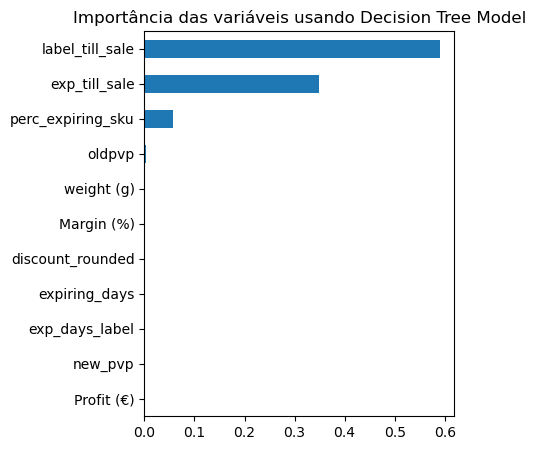

_________________________________________________________________________________________________

                                     DIVISÃO 2                                    
_________________________________________________________________________________________________

🔹 Variáveis mais importantes pela Decision Tree:
label_till_sale      0.592210
exp_till_sale        0.346293
perc_expiring_sku    0.057756
new_pvp              0.002870
Margin (%)           0.000870
oldpvp               0.000000
weight (g)           0.000000
Profit (€)           0.000000
exp_days_label       0.000000
expiring_days        0.000000
dtype: float64


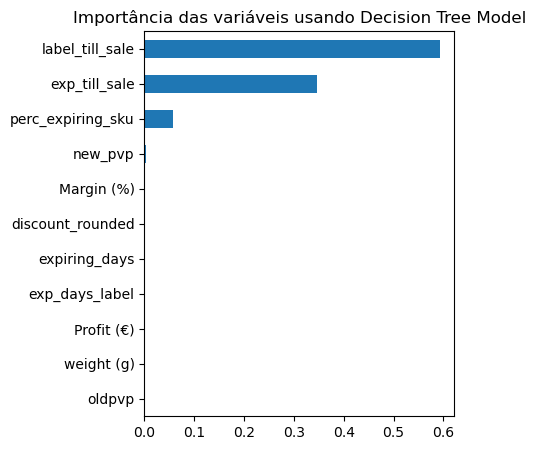

_________________________________________________________________________________________________

                                     DIVISÃO 3                                    
_________________________________________________________________________________________________

🔹 Variáveis mais importantes pela Decision Tree:
label_till_sale      0.589546
exp_till_sale        0.349035
perc_expiring_sku    0.057592
oldpvp               0.002765
Margin (%)           0.001062
weight (g)           0.000000
Profit (€)           0.000000
new_pvp              0.000000
exp_days_label       0.000000
expiring_days        0.000000
dtype: float64


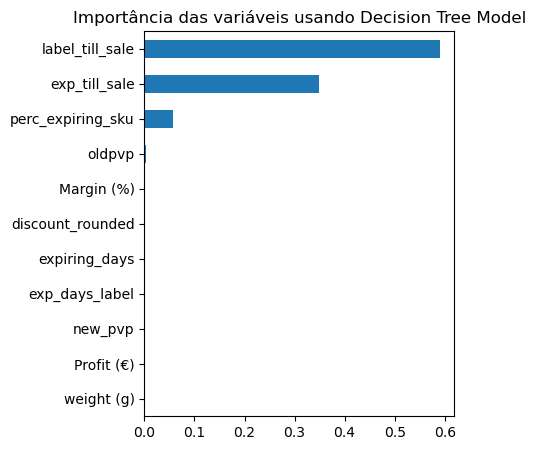

_________________________________________________________________________________________________

                                     DIVISÃO 4                                    
_________________________________________________________________________________________________

🔹 Variáveis mais importantes pela Decision Tree:
label_till_sale      0.588360
exp_till_sale        0.349206
perc_expiring_sku    0.058504
oldpvp               0.002809
Margin (%)           0.001121
weight (g)           0.000000
Profit (€)           0.000000
new_pvp              0.000000
exp_days_label       0.000000
expiring_days        0.000000
dtype: float64


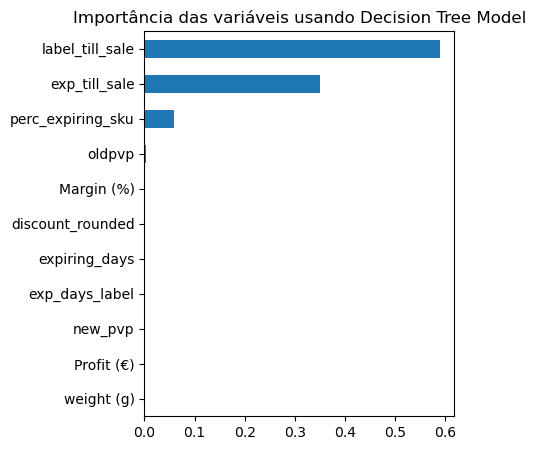

_________________________________________________________________________________________________

                                     DIVISÃO 5                                    
_________________________________________________________________________________________________

🔹 Variáveis mais importantes pela Decision Tree:
label_till_sale      0.589645
exp_till_sale        0.349722
perc_expiring_sku    0.056853
new_pvp              0.002899
Margin (%)           0.000880
oldpvp               0.000000
weight (g)           0.000000
Profit (€)           0.000000
exp_days_label       0.000000
expiring_days        0.000000
dtype: float64


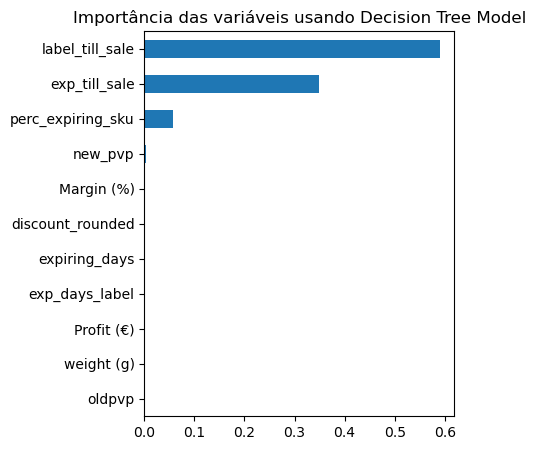

In [21]:
select_best_features_dt(X, y)

In [22]:
X = data.drop('sold', axis = 1)

In [23]:
def apply_rfe(X_train, y_train):
    rfe = RFE(estimator=LogisticRegression(penalty='l1', solver='liblinear'), n_features_to_select=5)
    rfe.fit_transform(X = X_train, y = y_train)
    selected_features = pd.Series(rfe.support_, index = X_train.columns)
    print(selected_features)

In [24]:
def apply_lasso_classification(X_train, y_train):
    if y_train.dtype == 'object' or y_train.dtype.name == 'category':
        le = LabelEncoder()
        y_train = le.fit_transform(y_train)

    lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
    lasso.fit(X_train, y_train)

    coef = pd.Series(lasso.coef_[0], index=X_train.columns)

    eliminated_features = coef[coef == 0].index.tolist()
    print(f"Variáveis eliminadas pelo Lasso: {eliminated_features}")


    plot_importance(coef, 'Lasso')


In [25]:
def select_best_features(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        numerical_data = X_train.drop(['idstore','sku','brand','Payment_method','type','district','labelling_weekday','sell_weekday'], axis = 1).copy()
        scaler = MinMaxScaler().fit(numerical_data)
        X_train_scaled = scaler.transform(numerical_data)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns = numerical_data.columns)
           
        print('_________________________________________________________________________________________________\n')
        print('                                     DIVISÃO ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')
        
        print('')
        print('----------------- RFE ----------------------')
        apply_rfe(X_train_scaled, y_train)
        
        print('')
        print('----------------- LASSO ----------------------')
        apply_lasso_classification(X_train_scaled, y_train)
            
        print('')
        print('----------------- DT ----------------------')
        apply_decision_tree(X_train_scaled, y_train)
            
        count+=1

_________________________________________________________________________________________________

                                     DIVISÃO 1                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
oldpvp               False
weight (g)           False
Margin (%)           False
Profit (€)            True
perc_expiring_sku     True
new_pvp              False
exp_days_label        True
expiring_days        False
discount_rounded     False
label_till_sale       True
exp_till_sale         True
dtype: bool

----------------- LASSO ----------------------
Variáveis eliminadas pelo Lasso: ['oldpvp', 'Margin (%)', 'expiring_days']


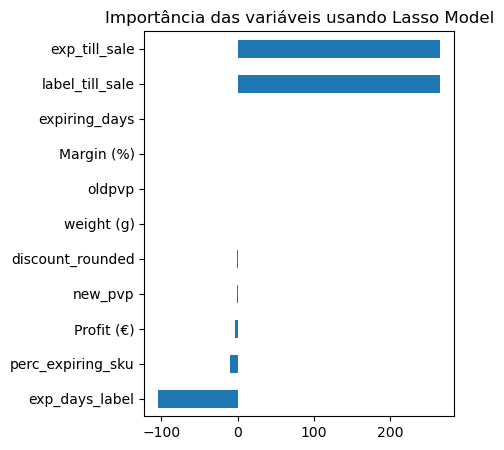


----------------- DT ----------------------

🔹 Variáveis mais importantes pela Decision Tree:
label_till_sale      0.589509
exp_till_sale        0.348262
perc_expiring_sku    0.058180
oldpvp               0.003087
weight (g)           0.000659
Margin (%)           0.000302
Profit (€)           0.000000
new_pvp              0.000000
exp_days_label       0.000000
expiring_days        0.000000
dtype: float64


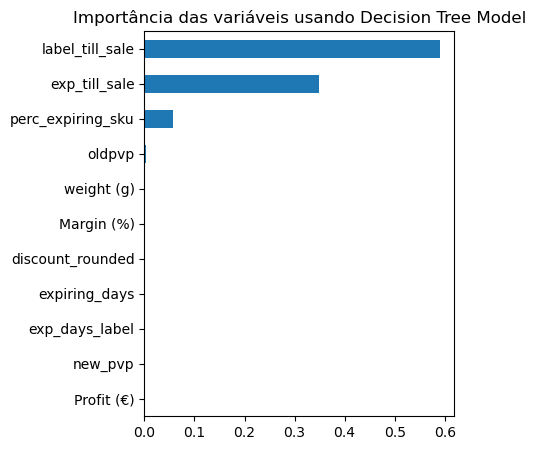

_________________________________________________________________________________________________

                                     DIVISÃO 2                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
oldpvp               False
weight (g)           False
Margin (%)           False
Profit (€)            True
perc_expiring_sku     True
new_pvp              False
exp_days_label        True
expiring_days        False
discount_rounded     False
label_till_sale       True
exp_till_sale         True
dtype: bool

----------------- LASSO ----------------------
Variáveis eliminadas pelo Lasso: ['oldpvp', 'expiring_days']


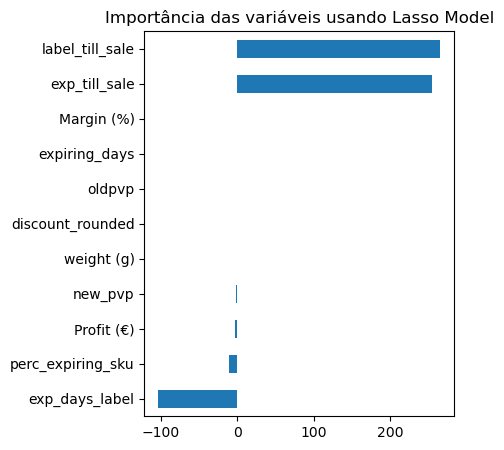


----------------- DT ----------------------

🔹 Variáveis mais importantes pela Decision Tree:
label_till_sale      0.592210
exp_till_sale        0.346293
perc_expiring_sku    0.057756
new_pvp              0.002870
Margin (%)           0.000870
oldpvp               0.000000
weight (g)           0.000000
Profit (€)           0.000000
exp_days_label       0.000000
expiring_days        0.000000
dtype: float64


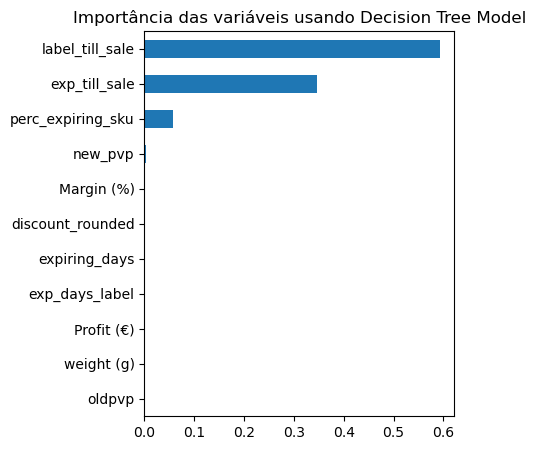

_________________________________________________________________________________________________

                                     DIVISÃO 3                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
oldpvp               False
weight (g)           False
Margin (%)           False
Profit (€)            True
perc_expiring_sku     True
new_pvp              False
exp_days_label        True
expiring_days        False
discount_rounded     False
label_till_sale       True
exp_till_sale         True
dtype: bool

----------------- LASSO ----------------------
Variáveis eliminadas pelo Lasso: ['oldpvp', 'expiring_days']


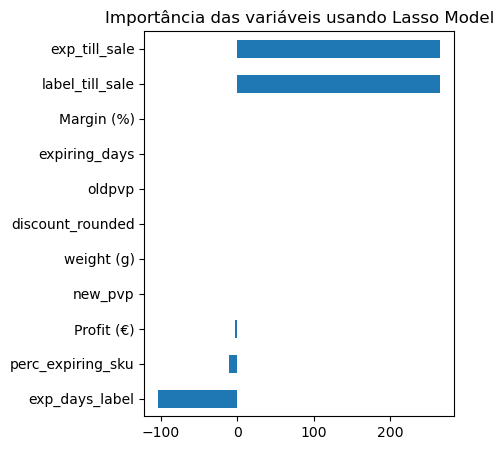


----------------- DT ----------------------

🔹 Variáveis mais importantes pela Decision Tree:
label_till_sale      0.589546
exp_till_sale        0.349035
perc_expiring_sku    0.057592
oldpvp               0.002765
Margin (%)           0.001062
weight (g)           0.000000
Profit (€)           0.000000
new_pvp              0.000000
exp_days_label       0.000000
expiring_days        0.000000
dtype: float64


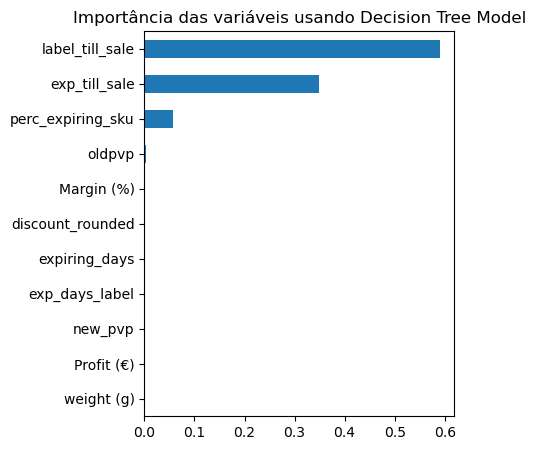

_________________________________________________________________________________________________

                                     DIVISÃO 4                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
oldpvp               False
weight (g)           False
Margin (%)           False
Profit (€)            True
perc_expiring_sku     True
new_pvp              False
exp_days_label        True
expiring_days        False
discount_rounded     False
label_till_sale       True
exp_till_sale         True
dtype: bool

----------------- LASSO ----------------------
Variáveis eliminadas pelo Lasso: ['oldpvp', 'expiring_days']


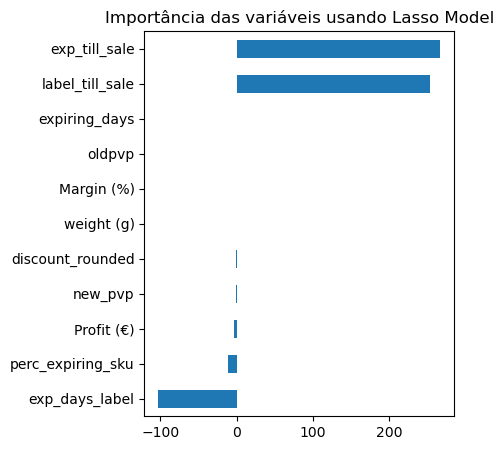


----------------- DT ----------------------

🔹 Variáveis mais importantes pela Decision Tree:
label_till_sale      0.588360
exp_till_sale        0.349206
perc_expiring_sku    0.058504
oldpvp               0.002809
Margin (%)           0.001121
weight (g)           0.000000
Profit (€)           0.000000
new_pvp              0.000000
exp_days_label       0.000000
expiring_days        0.000000
dtype: float64


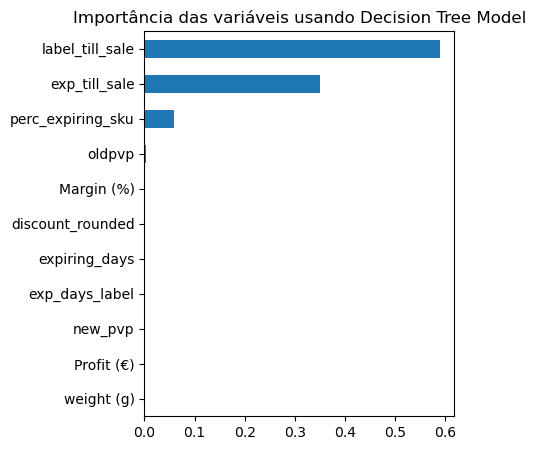

_________________________________________________________________________________________________

                                     DIVISÃO 5                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------


In [ ]:
select_best_features(X, y)

### Dados Numéricos

`Quais variáveis devemos manter utilizando estas técnicas?`

| Preditor | RFE | Lasso | DT | 
| --- | --- | --- | --- |
label_till_sale |X|X|X | | 
exp_till_sale |X|X|X | |
perc_expiring_sku |X|X|X||
new_pvp |X|X| - | |  
oldpvp | -  | - | X |  |
weight (g) | - | X | - |  |
Margin (%)| - | - | X  |  |
Profit (€)| X | X | - |  |
exp_days_label | X | X | - |  |
discount_rounded | -  | X | - |  |
expiring_days| -  | - | - |  |




### De acordo com os vários testes usados, temos a seguinte escolha de variáveis:

- As variáveis testadas com o método chisquare e variância verificam a relação das mesmas com o alvo, sold.
  Á partida entre ambos os testes escolheriamos o sku, o idstore, o weight (g), a Margin (%) e o expiring_days

-  Com o gráfico de correlação, retirámos as variáveis, percebemos que teriamos que tomar decisões em relação ás variáveis new_pvp, oldpvp e Profit que estão fortemente relacionadas, bem como exp_days_label e o perc_expiring_sku.

- Com os testes RFE, Lasso e DT, incluimos o discounte_rounded, o exp_till_sale, o expiring__days e o exp_days_label, por ter sido demonstrado nestes testes a sua importância.

In [ ]:
# Selecionar apenas as variáveis numéricas (sem a variável alvo 'sold')
X = data[['sku', 'idstore', 'oldpvp', 'weight (g)', 'Margin (%)', 'exp_days_label', 'discount_rounded', 'expiring_days']].copy()
y = data['sold']  # Variável alvo

# Garantir que X contenha apenas variáveis numéricas
X = X.select_dtypes(include=['number'])

# Tratar valores ausentes com imputação (usando média)
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Dividir os dados em treino e teste (30% teste, 70% treino) com estratificação na variável alvo
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, stratify=y, random_state=42)

# Criar dummies (caso haja alguma variável categórica)
X_train_dummies = pd.get_dummies(X_train)
X_test_dummies = pd.get_dummies(X_test)

# Garantir que X_test contenha as mesmas colunas que X_train
X_test_dummies = X_test_dummies.reindex(columns=X_train_dummies.columns, fill_value=0)

# Escalar os dados com MinMaxScaler
scaler = MinMaxScaler().fit(X_train_dummies)
X_train_scaled = scaler.transform(X_train_dummies)
X_test_scaled = scaler.transform(X_test_dummies)

# Converter para DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_dummies.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train_dummies.columns)

# Lista de modelos para testar
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Estrutura para armazenar os resultados utilizando apenas o método predict padrão
results = []

for model_name, model in models.items():
    # Treinar o modelo com os dados de treino escalonados
    model.fit(X_train_scaled, y_train)
    
    # Fazer a predição (retorna probabilidades)
    y_pred_proba = model.predict(X_test_scaled)
    
    # Definir um novo threshold (por exemplo, 0.3 para aumentar recall)
    threshold = 0.3
    y_pred = (y_pred_proba >= threshold).astype(int)

    
    # Cálculo das métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Armazenar os resultados para cada modelo
    results.append([model_name, acc, prec, rec, f1, conf_matrix])
    
# Criar DataFrame com os resultados
results_df = pd.DataFrame(results, columns=["Modelo", "Taxa de Acerto", "Precisão", "Recall", "F1-Score", "Matriz de Confusão"])

# Exibir os resultados
print(results_df)

- Taxa de Acerto: Mede o percentual de previsões corretas. O XGBoost teve a melhor Taxa de Acerto (0.689), seguido pelo Random Forest e Decision Tree.
- 
Precisão: Mede a taxa de verdadeiros positivos sobre todos os positivos previstos O XGBoost tem a maior precisão (0.699), o que indica menos falsos positivos, mas menor recall.
- 
Recall: Mede a capacidade do modelo de identificar positivos reais. A Regressão Logística teve o maior recall (0.802), o que significa que ele identificou mais casos reais da classe positiva
- .
F1-Score: Métrica balanceada entre precisão e recall. O XGBoost também teve o melhor F1-score (0.718), sugerindo um equilíbrio adequado entre as métrics.


In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

| **Previsto vs Real** | **Valor** | **Significado** |
|---------------------|----------|----------------|
| **Verdadeiro Negativo (TN)**  | **13.200**  | Casos corretamente previstos como negativos (0). |
| **Falso Positivo (FP)**       | **7.663**   | Casos que deveriam ser negativos, mas foram previstos como positivos. |
| **Falso Negativo (FN)**       | **6.304**   | Casos que deveriam ser positivos, mas foram previstos como negativos. |
| **Verdadeiro Positivo (TP)**  | **17.281**  | Casos corretamente previstos como positivos (1). |


In [ ]:
model = xgb.XGBClassifier()  
model.fit(X_train, y_train)

xgb.plot_importance(model, importance_type='gain') 
plt.show()

| **Variável**         | **F-score** | **Interpretação** |
|---------------------|------------|------------------|
| **oldpvp**          | **27.46**   | O preço antigo influencia a decisão, possivelmente em relação ao desconto. |
| **Margin (%)**      | **11.50**   | A margem de lucro tem impacto na previsão, mostrando que produtos com diferentes margens têm comportamentos distintos. |
| **weight (g)**      | **13.55**    | O peso do produto influencia a previsão, o que pode estar relacionado à categoria de produtos. |
| **sku**            | **11.57**    | O identificador do produto tem um impacto menor, mas relevante. |
| **expiring_days**   | **9.75**    | Dias até ao fim da validade contribuem para a previsão, mas com menos impacto do que "exp_till_sale". |
| **idstore**        | **6.75**    | A loja onde o produto está a ser vendido tem um impacto baixo na previsão. |
| **exp_days_label**  | **5.81**    | Número de dias entre a rotulagem e a expiração tem impacto, mas não tanto quanto "exp_till_sale". |
| **discount_rounded**        | **4.37**    | O novo preço do produto influencia a previsão, mas menos do que o preço antigo. |

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)

| **Variável**        | **Impacto no Modelo**  | **Interpretação** |
|---------------------|-----------------------|------------------|
| **idstore**         | **Médio**              | A loja onde o produto é vendido tem impacto significativo. Diferentes lojas podem influenciar as vendas. |
| **oldpvp**         | **Moderado**           | O preço antigo do produto tem impacto na previsão, podendo estar relacionado a estratégias de desconto. |
| **weight (g)**      | **Moderado**           | O peso do produto pode impactar a decisão, indicando possíveis padrões de compra associados ao tipo de item. |
| **sku**            | **Baixo**              | Identificação do produto tem impacto menor, mas relevante. |
| **Margin (%)**      | **Baixo**              | A margem de lucro tem um impacto pequeno na previsão. |
| **exp_days_label**  | **Alto**        | O tempo entre a etiquetagem e o fim de validade tem pouco impacto na previsão. |
| **expiring_days**   | **Alto**        | Dias até ao fim da validade afetam a previsão, mas menos que "exp_till_sale". |
| **discount_rounded**        | **Muito Baixo**        | O desconto não tem um grande impacto na decisão dos consumidores de comprarem mais ou menos. |

In [ ]:
model = models["XGBoost"]

model.fit(X_train_scaled, y_train)

y_train_prob = model.predict_proba(X_train_scaled)[:, 1]
y_test_prob = model.predict_proba(X_test_scaled)[:, 1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure(figsize=(10,5))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Treino (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='orange', lw=2, label='Teste (AUC = %0.2f)' % roc_auc_test)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC - Treino vs Teste')
plt.legend(loc="lower right")
plt.show()


O modelo apresenta bom desempenho, com AUC = 0.78 no treino e AUC = 0.75 no teste.
A diferença pequena entre as curvas sugere que não há overfitting significativo e que o modelo generaliza bem.